# Tutorial 11: DeepWalk and node2vec - Implementation details
  

Paper:
* [DeepWalk: Online Learning of Social Representation](https://arxiv.org/pdf/1403.6652.pdf)  
* [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)  

Code:

 * [node2vec doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=node2vec#torch_geometric.nn.models.Node2Vec)
 * [node2vec code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/node2vec.py)

# Setup

In [1]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid

/home/gab/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, 
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, 
                 p=1, q=1,                             # bias parameters
                 sparse=True).to(device)

# Random walks

### The data loader

In [4]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

In [5]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28

In [6]:
idx, (pos_rw, neg_rw)= next(enumerate(loader))

In [7]:
idx

0

In [8]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [9]:
pos_rw

tensor([[2231, 2182, 2133,  ..., 2054,  456,  544],
        [2648,  243,  473,  ..., 2473, 2648, 1532],
        [2374,   20, 2270,  ...,  648, 1441,  750],
        ...,
        [2274, 1370, 2485,  ..., 1690, 2112, 2030],
        [2238, 2239, 2238,  ...,  789, 1703,   22],
        [1176,  295, 1176,  ...,  402, 1936,  507]])

In [10]:
neg_rw

tensor([[2231, 1961, 2140,  ...,  592, 1945, 1513],
        [2648,  285, 2520,  ...,  983,  148,  310],
        [2374, 1799,  847,  ...,   51, 2081, 1398],
        ...,
        [2704, 2401, 2076,  ...,    1, 2123, 2192],
        [2313,  726,  449,  ..., 1250,  532,  978],
        [2327, 1816, 1919,  ...,   97,  652, 2438]])

### Visualization

In [11]:
import networkx as nx 
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

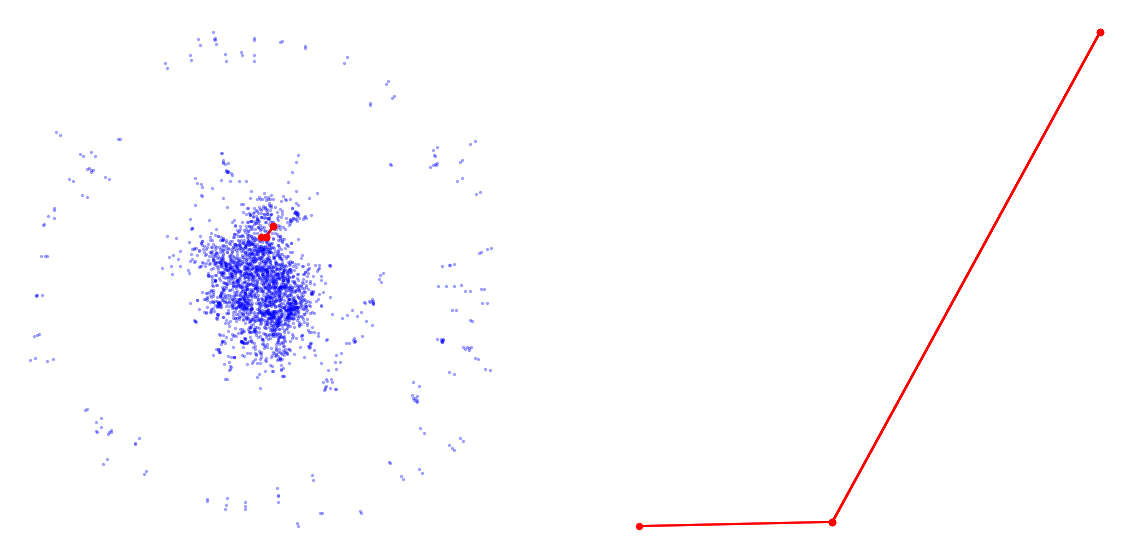

In [12]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

In [13]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


In [14]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        print(pos_rw.shape)
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [15]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [16]:
for epoch in range(1, 11):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([2200, 10])
Epoch: 01, Loss: 8.1538, Acc: 0.1580
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torch.Size([14080, 10])
torc

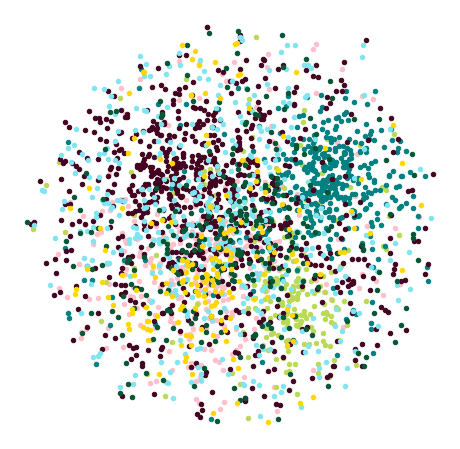

In [17]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)